Loop to iterate over  parameter values.

In [1]:
import requests
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import spearmanr
import pickle
import time
import os
import random

# Vital function for pairwise distances...
from scipy.spatial.distance import pdist

# For Dendrogram..
from scipy.cluster.hierarchy import linkage, dendrogram

# Clustering based on cophenetic distance
from scipy.cluster.hierarchy import fcluster

## 1. Reading SimLex-999

In [2]:
%run ConceptNet_VSA_AuxFunctions.ipynb  #To use reading functions

# Getting list of concepts
Pairs, Concepts = Read_SimLex()
Pairs.sort(key= lambda x: x[2])

# Getting partitions
Groups = CreatingPartitions()

# Getting list of pairs
GPairs = Pairs_per_Partition()

# Getting semantic features file
Feat_matrix = Reading_Feature_Matrix()
Feat_matrix[0][0]

There are 751 concepts
There are 137 partitions


['bed', 'RelatedTo', 'sleeping', ['sleep'], 14.61204982, 5.0]

#### Converting Feat_matrix to dictionary

Access information efficiently

In [3]:
def Feat_dict_fun():
    Feat_dict = {}
    for con in Feat_matrix:
        # Concept name is main key...
        Feat_dict[con[0][0]] = {}
        # feat_names in definition
        feat_names = list(set([x[1] for x in con]))
        # Dictionary for a single feat name of con
        #Dict_feat_name = {}
        for feat_nm in feat_names:
            Feat_dict[con[0][0]][feat_nm] =  [x[2:] for x in con if x[1] == feat_nm]
    return Feat_dict

Feat_dict = Feat_dict_fun()

## 2. Measuring semantic similarity of SimLex-999 pairs with several parameter values

It iterates over parameters to find the best values.
This loop can take a lot of time. Each iteration takes 20 minutes.
The next cell shows the correlation values obtained after several trials

In [4]:
%run EncodingDataset.ipynb
# Bucle sobre diff_bits...
min_w = 2
min_feat = 3
for diff_bits in [4600]: #range(2200, 4800, 200): 
    for max_d in [.7]: # range(.5, .8, .1)
        print "\n\nDiff_bits:", diff_bits, 
        print "   Max_d:", max_d,

        # Encoding
        Init_mem(Concepts, Feat_matrix, 2) 
        
        for i_g in range(len(Groups)): 
            Grupo = Groups[i_g]  
            PGrupo = GPairs[i_g] 
            GRelatedness = [x[2] for x in PGrupo]

            list_files_features = os.listdir('../Data/ClusteringData/03 Features_Group/') 
            features_files_group_i = [f for f in list_files_features if '_' + str(i_g) +'_' in f]

            list_files_X = os.listdir('../Data/ClusteringData/04 PairwiseDistance/')  
            X_mat_files_group_i = [f for f in list_files_X if '_' + str(i_g) +'_' in f]

            # Sanity check...
            assert len(features_files_group_i) == len(X_mat_files_group_i)

            Relations = map(extrac_relation_name, features_files_group_i)

            Dict_Features_Grupo_i = {}
            Dict_Distances_Grupo_i = {}

            for i in range(len(X_mat_files_group_i)):
                name_relation = extrac_relation_name(X_mat_files_group_i[i])
                Dict_Features_Grupo_i[name_relation] = np.load('../Data/ClusteringData/03 Features_Group/' + features_files_group_i[i])
                Dict_Distances_Grupo_i[name_relation] = np.load('../Data/ClusteringData/04 PairwiseDistance/' + X_mat_files_group_i[i])

            # Loop over relations
            for rela in Relations:
                # Linkage
                distance = linkage(Dict_Distances_Grupo_i[rela], 'average')
                # Clustering by distance
                clusters = fcluster(distance, max_d, criterion='distance')
                # Grouping features in clusters
                uniques = np.unique(clusters)
                Features = Dict_Features_Grupo_i[rela]
                Clusters = []
                for i in uniques:
                    Clusters.append([Features[j][0] for j in range(len(clusters)) if clusters[j] == i])

                # Changing ID_vectors
                for cluster in Clusters:  
                    if len(cluster) > 1:
                        change_dict_defs(Grupo, rela, cluster, i_g)
                        seed = cluster[0]
                        seed = seed + '_' + rela[:5] + rela[-2:] + "_g" + str(i_g)
                        seed_vec = SparseBitString(N)
                        HDvector(seed_vec, seed)
                        for word in cluster[1:]:
                            HDvector(contamina_vec(seed_vec, diff_bits), word + '_' + rela[:5] + rela[-2:] + "_g" + str(i_g))

            # New semantic pointers..
            for conc in Grupo:
                vec_ID = Dict[conc]
                vec_ID.setPointer(CreateSemanticPointer(Dict_defs[conc]))         

        # Filters 
        for concept in Concepts:
            # Step 1. Get pairs...
            pairs_con = get_Pairs(concept)

            # Iterating over pairs...
            Intersec_delete = []
            for pairr in pairs_con:
                # Step 3. Comparing distance between feat_values with equal feat_name...
                if pairr[0] == concept:
                    i_c = 0; i_oth = 1
                else:
                    i_c = 1; i_oth = 0

                Delete_list = []
                for feature in Dict_defs[pairr[i_c]]:
                    # Features of the other concept... with same feature_name as feature...
                    feats_con2 = get_feat_values(Dict_defs[pairr[i_oth]], feature[0])
                    # Measuring distance between feature[1] and feature_values from other concept...
                    distann = map(lambda x: Dict[feature[1]].dist(Dict[x]), feats_con2)
                    if len(distann) == 0 or min(distann) > 4000:
                        Delete_list.append(feature)

                Intersec_delete.append(Delete_list)

            to_delete_features = reduce(intersection, Intersec_delete)
            new_to_delete_features = []
            for to_del in to_delete_features:
                for val in Feat_dict[concept][to_del[0]]:
                    if val[0] == delete_relation_code(to_del[1]) and  val[2] <= min_w:  # Use auxiliar function (delete _isaisa_gX) 
                            new_to_delete_features.append(to_del)

            # Deleting from definition
            if len(Dict_defs[concept]) - len(new_to_delete_features) >= min_feat:
                Dict_defs[concept] = [x for x in Dict_defs[concept] if x not in new_to_delete_features]
                Dict[concept].setPointer(CreateSemanticPointer(Dict_defs[concept]))
            elif len(Dict_defs[concept]) >= min_feat:
                sample_to_delete = random.sample(new_to_delete_features, len(Dict_defs[concept]) - min_feat)
                Dict_defs[concept] = [x for x in Dict_defs[concept] if x not in sample_to_delete]
                Dict[concept].setPointer(CreateSemanticPointer(Dict_defs[concept]))
            
        # Measuring similarity
        HD_sim = []

        #Loop over pair
        for p in Pairs:
            HD_sim.append(HDvector.dist(Dict[p[0]].getPointer(), Dict[p[1]].getPointer()))

        # Max-min normalization of HD_sim... 
        max_sim = float(max(HD_sim))
        min_sim = float(min(HD_sim))
        HD_sim = map(lambda x: (1. - (float(x) - min_sim) / (max_sim - min_sim)) * 10, HD_sim)
        # Correlation
        print "\n    Spearman correlation coefficient: ", spearmanr(HD_sim, [x[2] for x in Pairs])[0]



Diff_bits: 4600    Max_d: 0.7 Begining to encode dataset...
End of encoding

    Spearman correlation coefficient:  0.6141890115138305


## Plotting correlation values.

Correlation values get after several iterations from the previous cell

C:\Users\jobqu\Anaconda2\lib\site-packages\matplotlib\pyplot.py:3261: RuntimeWarning: Second argument 'y1' is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)
C:\Users\jobqu\Anaconda2\lib\site-packages\matplotlib\pyplot.py:3261: RuntimeWarning: Second argument 'y2' is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)
C:\Users\jobqu\Anaconda2\lib\site-packages\matplotlib\pyplot.py:3261: RuntimeWarning: Second argument 'y3' is ambiguous: could be a color spec but is in data. Using as data.
Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


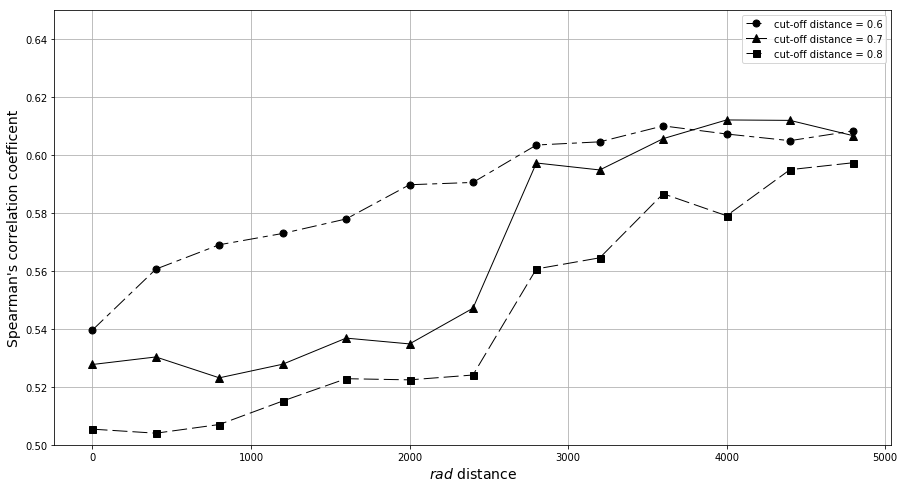

In [5]:
% matplotlib inline
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



# Data
df=pd.DataFrame({'x': range(0,4900,400), 
                 'y1': np.array([0.5396,0.5606,0.569,.5729,0.5779,0.5897,0.5905,0.6034,0.6045,0.61,0.6072,0.6049,0.6083]),
                 'y2': np.array([0.5277,0.5303,0.5231,0.5278,0.5368,0.5348,0.5471,0.5972,0.5948,0.6056,0.61205,0.6119,0.6066]),
                 'y3': np.array([0.5054,0.5040,0.507,0.5151,0.5228,0.5224,0.52407,0.56065,0.5645,0.5866,0.579,0.5949,0.5973])})
                                    
# multiple line plot
fig= plt.figure(figsize=(15,8))

plt.plot( 'x', 'y1', data=df, marker='o', color='black', markersize = 7, linestyle=(0,(15,5,5,5)), linewidth=1, label="cut-off distance = 0.6")
plt.plot( 'x', 'y2', data=df, marker='^', color='black', markersize = 8, linestyle='solid', linewidth=1, label="cut-off distance = 0.7")
#plt.plot( 'x', 'y2', data=df, marker='^', color='black', linestyle='dashdot', linewidth=1, label="cut-off = 0.7")
plt.plot( 'x', 'y3', data=df, marker='s', color='black', markersize = 7, linestyle=(0, (15,5)), linewidth=1, label="cut-off distance = 0.8")
#plt.plot( 'x', 'y3', data=df, marker='s', coor='black', linestyle='dashed', linewidth=1, label="cut-off = 0.8")
plt.xlabel('$\it{rad}$ distance', fontsize=14)
plt.ylabel("Spearman's correlation coefficent", fontsize=14)
plt.ylim(.5, .65)# .65)

plt.grid()
plt.legend()
